In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install ngboost

In [2]:
!pip install h2o

     |████████████████████████████████| 128.3MB 55kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.3-py2.py3-none-any.whl size=128358449 sha256=d00c6a6d41173b477f0824f30fe513012608db4eadff974208ae3dd95541570b
  Stored in directory: /root/.cache/pip/wheels/8e/66/2c/0c2137d104352c2e6fb1991d496e5857ee17d39884b5b25b96
Successfully built h2o


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import log_loss, accuracy_score

from lightgbm import LGBMClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# from ngboost import NGBClassifier
# from ngboost.ngboost import NGBoost
# from ngboost.scores import LogScore, MLE
# from ngboost.distns import Bernoulli, categorical
# from ngboost.learners import default_tree_learner

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_data = pd.read_csv('/content/drive/My Drive/Glass Quality Prediction/Train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Glass Quality Prediction/Test.csv')
ss = pd.read_excel('/content/drive/My Drive/Glass Quality Prediction/Sample_Submission.xlsx')

# Exploratory Data Analysis

In [5]:
train_data.nunique()

grade_A_Component_1       2
grade_A_Component_2       2
max_luminosity          131
thickness               143
xmin                    775
xmax                    811
ymin                   1358
ymax                   1358
pixel_area              813
log_area               1358
x_component_1             2
x_component_2             2
x_component_3             2
x_component_4             2
x_component_5             2
class                     2
dtype: int64

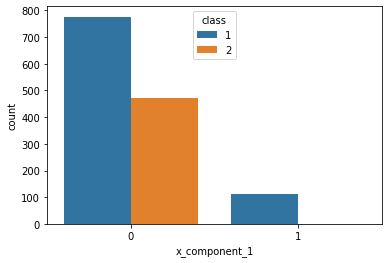

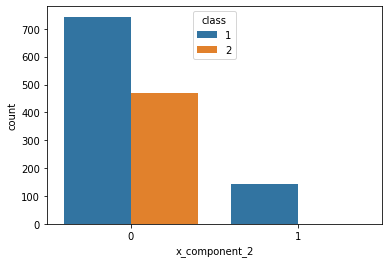

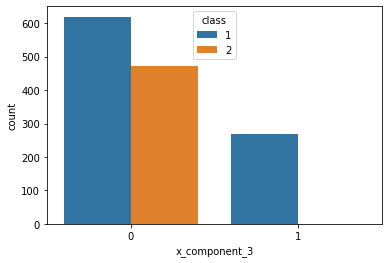

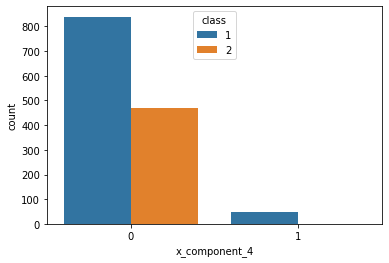

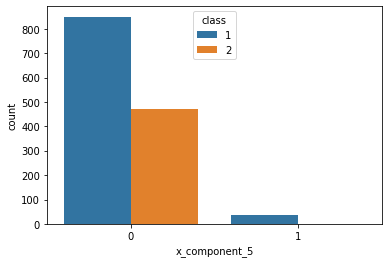

In [7]:
col = 'x_component_1'
sns.countplot(train_data[col], hue=train_data['class'])
plt.show()

col = 'x_component_2'
sns.countplot(train_data[col], hue=train_data['class'])
plt.show()

col = 'x_component_3'
sns.countplot(train_data[col], hue=train_data['class'])
plt.show()

col = 'x_component_4'
sns.countplot(train_data[col], hue=train_data['class'])
plt.show()

col = 'x_component_5'
sns.countplot(train_data[col], hue=train_data['class'])
plt.show()

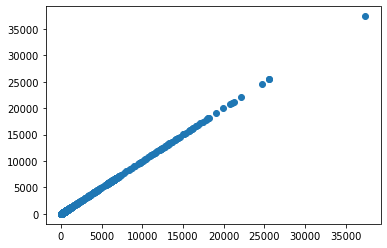

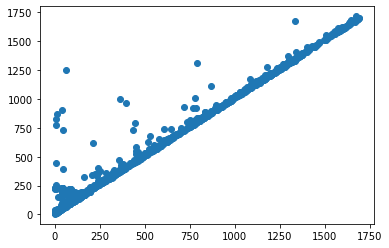

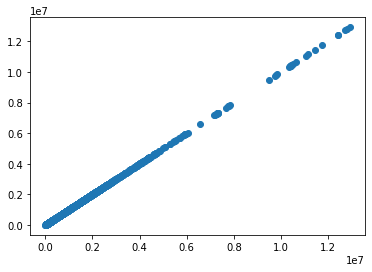

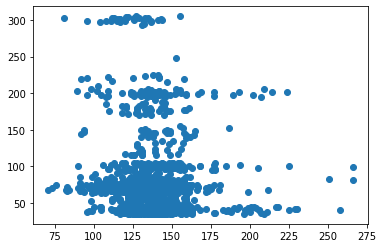

In [13]:
# You can see that xmin, xmax or ymin, ymax or logarea and pixel area are having relationship
plt.scatter(train_data['log_area'],train_data['pixel_area'])
plt.show()

plt.scatter(train_data['xmin'],train_data['xmax'])
plt.show()

plt.scatter(train_data['ymin'],train_data['ymax'])
plt.show()

plt.scatter(train_data['max_luminosity'],train_data['thickness']) # this doesn;t have any relationship though
plt.show()

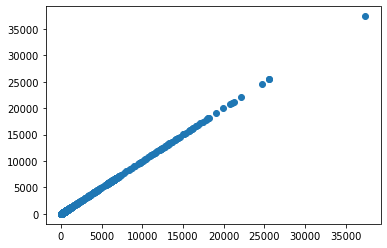

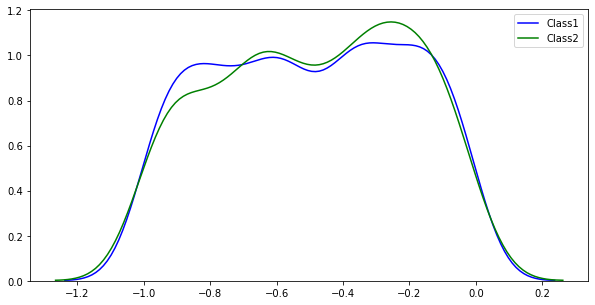

In [14]:
# Both tells that log_area is redundant feature
plt.scatter(train_data['log_area'],train_data['pixel_area'])
plt.show()

col = 'pixel_area'
col2 = 'log_area'
plt.figure(figsize=(10,5))
sns.distplot(train_data[train_data['class'] == 1][col]-train_data[train_data['class'] == 1][col2], color='b', label='Class1', hist=False)
sns.distplot(train_data[train_data['class'] == 2][col]-train_data[train_data['class'] == 2][col2], color='g', label='Class2', hist=False)
plt.legend(loc='best')

# Observations from EDA
1. From above x-components countplot we can say that whenever any one of the x-component is 1 then it is surely class 1. When it is zero, we need to think of it. Around 609 data-points are classified without training. But AutoML GBM is taking care of this automatically.
2. Lineaarly dependent features are also found from these

In [15]:
# Using x_components we can predict almost 45% of data which is awesome:)
print("Train prediction without training : {:.2f}%".format((train_data[(train_data['x_component_1'] == 1) | (train_data['x_component_2'] == 1) | 
                                                                       (train_data['x_component_3'] == 1) | (train_data['x_component_4'] == 1) | 
                                                                       (train_data['x_component_5'] == 1)].shape[0] / train_data.shape[0]) * 100))

Train prediction without training : 44.85%


In [18]:
train_data[train_data[['x_component_5','x_component_1','x_component_2','x_component_3','x_component_4']].sum(axis=1) == 1].shape

(609, 16)

In [19]:
# This part is taken from machine hack solutions in one of their hackathons, I am using that as a reference
def get_rules_ids(df):
    idx_df = df[(df['x_component_1'] == 1) | (df['x_component_2'] == 1) | (df['x_component_3'] == 1) |(df['x_component_4'] == 1) |
                (df['x_component_5'] == 1)].index
    return idx_df

idx_train = get_rules_ids(train_data)
idx_test = get_rules_ids(test_data)

train_pre = train_data.copy()
test_pre = test_data.copy()

train_pre.drop(idx_train, axis=0, inplace=True)
test_pre.drop(idx_test, axis=0, inplace=True)


train_pre.reset_index(inplace=True)
test_pre.reset_index(inplace=True)

train_pre.drop(['x_component_5','x_component_1','x_component_2','x_component_3','x_component_4',
                'log_area','xmax','ymax'],
               axis=1, inplace=True)
test_pre.drop(['x_component_5','x_component_1','x_component_2','x_component_3','x_component_4',
               'log_area','xmax','ymax'],
              axis=1, inplace=True)

# # Following turned out to be top 4 features in xgg shallow classifier
# train_pre['ydiff'] = train_pre['ymax'] - train_pre['ymin']
# test_pre['ydiff'] = test_pre['ymax'] - test_pre['ymin']

# train_pre['ydiv'] = train_pre['ymax']/train_pre['ymin']
# test_pre['ydiv'] = test_pre['ymax']/test_pre['ymin']

# train_pre['xdiff'] = train_pre['xmax'] - train_pre['xmin']
# test_pre['xdiff'] = test_pre['xmax'] - test_pre['xmin']

# train_pre['xdiv'] = train_pre['xmax']/train_pre['xmin']
# test_pre['xdiv'] = test_pre['xmax']/test_pre['xmin']

# train_pre['feat1'] = train_data['thickness']*train_data['grade_A_Component_1']
# test_pre['feat1'] = test_data['thickness']*test_data['grade_A_Component_1']

# train_pre['feat2'] = train_data['max_luminosity']*train_data['grade_A_Component_2']
# test_pre['feat2'] = test_data['max_luminosity']*test_data['grade_A_Component_2']

train_pre.to_csv("/content/drive/My Drive/Glass Quality Prediction/Train4.csv", index=False)
test_pre.to_csv("/content/drive/My Drive/Glass Quality Prediction/Test4.csv", index=False)

print("New Train Shape : {}\nNew Test Shape :  {}".format(train_pre.shape, test_pre.shape))

New Train Shape : (749, 9)
New Test Shape :  (326, 8)


# Feature Engineering

In [0]:
# Above 203 its class 2(check manually setting this),
# atleast we can say above 300 surely class2, lets just not overfit this condition
# test_data[(test_data['thickness']*test_data['grade_A_Component_1'])>300] did manually here, sub4
feat1 = train_data['thickness']*train_data['grade_A_Component_1'] 

# its now >180 of this can be class 2 lets check this submission
feat2 = train_data['max_luminosity']*train_data['grade_A_Component_2']
#feat2 = np.log(train_data['thickness']*train_data['max_luminosity'])--> already solved that row by feat 1

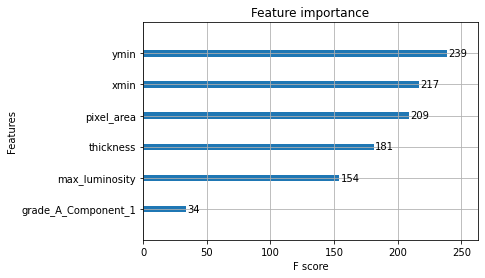

In [21]:
clf = xgb.XGBClassifier(max_depth=4).fit(train_pre.drop(['class','index'],axis=1),train_pre['class'])
xgb.plot_importance(clf)

# AutoML

In [0]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,21 mins 28 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_49ppho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.047 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [0]:
from h2o.automl import H2OAutoML

df = h2o.import_file('/content/drive/My Drive/Glass Quality Prediction/Train4.csv')
testing_df = h2o.import_file('/content/drive/My Drive/Glass Quality Prediction/Test4.csv')

#Since this is classification problem, converting target as factor
df['class'] = df['class'].asfactor()

train,test,valid = df.split_frame(ratios=[.85,0.10],seed=11)

y = "class"
x = df.columns
x.remove(y)

aml = H2OAutoML(nfolds=10,
    balance_classes=True,
    class_sampling_factors=None,
    max_after_balance_size=5.0,
    max_runtime_secs=None,
    max_runtime_secs_per_model=None,
    max_models=None,
    stopping_metric='AUTO',
    stopping_tolerance=None,
    stopping_rounds=None,
    seed=4,
    project_name=None,
    exclude_algos=['DeepLearning'],
    include_algos=None,
    exploitation_ratio=0,
    modeling_plan=None,
    monotone_constraints=None,
    algo_parameters=None,
    keep_cross_validation_predictions=True,
    keep_cross_validation_models=False,
    keep_cross_validation_fold_assignment=True,
    sort_metric='logloss',
    export_checkpoints_dir=None,
    verbosity='warn',
)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
aml.train(x = x, y = y, training_frame = train, validation_frame=valid)

AutoML progress: |
06:30:51.104: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [0]:
lb = aml.leaderboard
lb

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20200524_063051_model_4,0.51935,0.803964,0.872211,0.293386,0.417057,0.173936
GBM_grid__1_AutoML_20200524_063051_model_7,0.523714,0.797184,0.86955,0.314787,0.420407,0.176742
StackedEnsemble_BestOfFamily_AutoML_20200524_063051,0.52393,0.801996,0.869667,0.273226,0.417319,0.174155
DRF_1_AutoML_20200524_063051,0.526643,0.802028,0.869004,0.292558,0.420603,0.176907
GBM_grid__1_AutoML_20200524_063051_model_2,0.526677,0.794187,0.868575,0.319413,0.42151,0.177671
StackedEnsemble_AllModels_AutoML_20200524_063051,0.527251,0.799746,0.868962,0.260218,0.419125,0.175666
XRT_1_AutoML_20200524_063051,0.528022,0.800468,0.867501,0.313938,0.420214,0.17658
GBM_2_AutoML_20200524_063051,0.532369,0.793704,0.862507,0.363074,0.423278,0.179164
GBM_grid__1_AutoML_20200524_063051_model_3,0.532992,0.790643,0.863541,0.289216,0.423707,0.179528
GBM_grid__1_AutoML_20200524_063051_model_8,0.534536,0.785279,0.860533,0.273661,0.424312,0.180041


In [0]:
pred_df = aml.leader.predict(testing_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
final_submission = pd.DataFrame(columns=ss.columns,index=test_data.index)
final_submission['index'] = np.arange(0,583)
for i in range(len(final_submission)):
  if final_submission.iloc[i]['index'] in idx_test:
    final_submission.iloc[i] = [0.9999,0.0001,i]

for i in range(len(final_submission)):
  if final_submission.iloc[i]['index'] in test_pre['index'].values.tolist():
    found_index = test_pre[test_pre['index'] == final_submission.iloc[i]['index']].index.values[0]
    pred_df_pandas = pred_df[['p1','p2']].as_data_frame()
    final_submission.iloc[i] = [pred_df_pandas.iloc[found_index]['p1'],pred_df_pandas.iloc[found_index]['p2'],i]

In [0]:
final_submission.drop(['index'],axis=1,inplace=True)
final_submission.to_excel('Submission_16_GBM_FE.xlsx',index=False)

# Overview of my competition submission details
1. Basemodel with 5 fold lgbm gives score around 0.29051
2. GBM gives 0.27956 on public leaderboard
3. X_components are removed and AutoML GBM score is 0.25453(sudden jump in score is huge here) -- this without using feat1.
4. Sub 4: Sub3 is changed with one extra condition that gradeAComp1*thickness > 300 gives class 2, score is 0.25337.

This put me in Leaderboard 4 in public, Some mistake has happend which i didnt know even now why my private leaderboard is worse. I would like to know if any of you wrong in my approach